# Classifying Jungian Cognitive Functions from Text Input as a Means to Predict Personality

# What are Jungian Cognitive Functions?

The famous 20th century psychologist Carl Jung formulated a theory of personality that included the identification
of 8 cognitive functions that would help explain the differences between how different people processed information.  


Jung theorized that each person possesses a primary method of perceiving the world (perception in this case meaning
the manner in which they filter and encode  information extracted from their senses) and a primary method 
of judging those perceptions.  Jung believed people either perceive via what he referred to as sensing or intuition
and in either internalized or externalized orientations(introverted vs extraverted).    He also identified
judgment as either through what he called "feeling" or "thinking" in either introverted or extraverted manners. 
Therefore, per the jungian theory, each person possess a primary method of perception (introverted intuition,
extraverted intution, introverted sensing or extraverted sensing) and a primary method of judgment (
introverted feeling, extraverted feeling, introverted thinking, extraverted thinking).   They also cannot possess
primary perceiving and judging functions that are of the same orientation meaning that for example one cannot
possess both extraverted perception and extraverted judgment.  Instead, per the classification system,
one must possess one extraverted primary cognitive function and one introverted primary cognitive function.

Note that the more popular Myers Briggs Type Indicator was created somewhat based on these Jungian cognitive functions
but instead assigned 4 basic dichotomies for introversion/extraversion, sensing/intuition, feeling/thinking and
perceiving/judging.  

The purpose of this project is to try and determine if processing text can predict the Jungian Functions
the author of the text possesses.  Note that we will classify functions in this case one by one and try to
find which methods work best in classifying each cognitive function separately.  We will not necessarily simply
use multiclass classification as what model works best in predicting one cognitive function may not work best in 
predicting another.  

The dataset used included MBTI type information and a list of user posts from the personalitycafe.com 
forum.  


# Approach

1. Import libraries and read in the the data
2. Plot the distribution of MBTI types variables given in the dataset
3. Plot the distribution of the cognitive functions(our potential target) extracted from the MBTI types
4. Balance cognitive function classes in our data by downsampling
5. Split the data into train-test sets
6. Clean the post data- remove punctuation, lowercase all letters, etc
    - Gather structural variables (post length, sentence length)
    - Gather punctuation variables (question count, comma count, exclamation count)
    - Gather media variables(video counts, image counts)
7. Combine all of each users posts into one long string
8. TFIDF Vectorizer- get all of the words in the users posts and how many times they used them
9. Use ngrams to get bigrams and trigrams used by users
10. Show the most popular words,bigrams used by users that possess each cognitive function
11. Place the nonword variables (structural,punctuation,media variables) into a series of machine learning model s to see if they can accurately predict cogntive function usage, see which model performs best.   Use binary classifiers for the presence of each function.  Get AUC, logloss, mse metrics. 
12. Dimensionality Reduction- Truncated SVD on the word vectors
13. Use word vectors as features and plug them into series of binary classifiers predicting each cognitive function to see which performs best.  
14. Try combining vectorized features and nonword features.  Place them into a series of binary classifiers.
15. Try formulating word groups that intuitively may relate to different personalities and see if they can act as good predictors of cognitive functions.
16. Record the features and models that perform the best in predicting each cognitive function.     
17. Perform hyperparameter tuning on our models to improve model performance
18. Set our optimal models for each cognitive function and integrate sample data 
19. Test our final model on sample data


# Import Libraries and Read in the CSV


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import sklearn
import warnings
from collections import Counter
warnings.filterwarnings('ignore')
df = pd.read_csv('mbti_1.csv')

# Plotting MBTI Type

The original dataset used here included two columns- one listing a myers briggs personality type
and the other listing a string of posts submitted on an online personality forum.

Text(0.5, 1.0, 'MBTI Type Distribution')

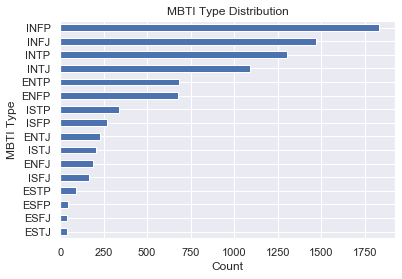

In [2]:
count = Counter(df)
X = pd.DataFrame.from_dict(count, orient='index')
sb.set()
types_count = df.iloc[:,0].value_counts()
types_count.sort_values(ascending=True).plot('barh')
plt.xlabel("Count")
plt.ylabel("MBTI Type")
plt.title("MBTI Type Distribution")

# Plotting the Initial Distribution of Cognitive Functions

Jungian cognitive functions underlie the MBTI personality type indicator and include four functions for 
perceiving (Introverted Intuition, Extraverted Intution, Introverted Sensing, Extraverted Sensing) and four
functions for judging (Introverted Thinking, Extraverted Thinking, Introverted Feeling, Extraverted Feeling).

These 4 functions can be garnered based off the MBTI types.  The 2 primary cogntive functions (one for perceiving and one for judging) 
will be extracted as a means to later classify them.   

Text(0, 0.5, 'Count')

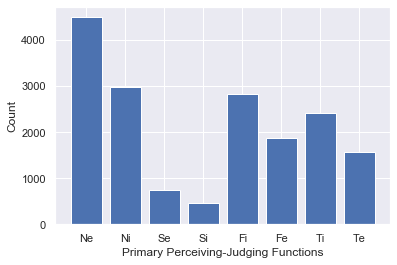

In [3]:
df["Ne"] = [1 if x[-1] == 'P' and x[1] == 'N' else 0 for x in df.iloc[:,0]]
df["Ni"] = [1 if x[-1] == 'J' and x[1] == 'N' else 0 for x in df.iloc[:,0]]
df["Se"] = [1 if x[-1] == 'P' and x[1] == 'S' else 0 for x in df.iloc[:,0]]
df["Si"] = [1 if x[-1] == 'J' and x[1] == 'S' else 0 for x in df.iloc[:,0]]
df["Fi"] = [1 if x[-1] == 'P' and x[2] == 'F' else 0 for x in df.iloc[:,0]]
df["Fe"] = [1 if x[-1] == 'J' and x[2] == 'F' else 0 for x in df.iloc[:,0]]
df["Ti"] = [1 if x[-1] == 'P' and x[2] == 'T' else 0 for x in df.iloc[:,0]]
df["Te"] = [1 if x[-1] == 'J' and x[2] == 'T' else 0 for x in df.iloc[:,0]]

columns_to_use = np.array(df.columns[2:])
counts = df.iloc[:,2:].apply(np.sum,axis=0)
plt.bar(columns_to_use,counts)
plt.xlabel("Primary Perceiving-Judging Functions")
plt.ylabel("Count")

# Downsample the Data as a Means Balance the Cognitive Functions 

To help generalize our personality predictor, we want to make sure that each cognitive function is 
equally represented.

In our dataset, the Ne and Ni cognitive functions are especially overrepresented which means that if we use
the entirety of the data, the model will likely be biased.  

Downsampling the data will balance the cogntive functions in the dataset and ensure they are all represented equally. 


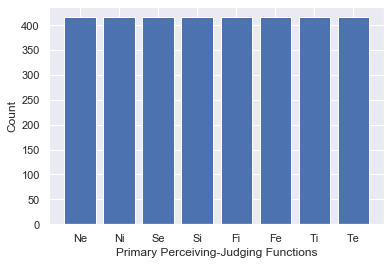

In [4]:
from sklearn.utils import resample

# Cognitive Functions are determined by the last 3 letters of MBTI Type, so isolate the last three letters

df["NFP"] = [1 if x == 'INFP' or x =='ENFP' else 0 for x in df.iloc[:,0]]
df["NFJ"] = [1 if x == 'INFJ' or x == 'ENFJ' else 0 for x in df.iloc[:,0]]
df["NTP"] = [1 if x == 'ENTP' or x =='INTP' else 0 for x in df.iloc[:,0]]
df["NTJ"] = [1 if x == 'ENTJ' or x == 'INTJ' else 0 for x in df.iloc[:,0]]
df["STJ"] = [1 if x == 'ESTJ' or x == 'ISTJ' else 0 for x in df.iloc[:,0]]
df["STP"] = [1 if x == 'ESTP' or x == 'ISTP' else 0 for x in df.iloc[:,0]]
df["SFP"] = [1 if x == 'ESFP' or x == 'ISFP' else 0 for x in df.iloc[:,0]]
df["SFJ"] = [1 if x == 'ESFJ' or x == 'ISFJ' else 0 for x in df.iloc[:,0]]
df["E"] = [1 if x[0] == 'E' else 0 for x in df.iloc[:,0]]


# Resample the data Function
def resample_df(df,samples):
    downsampled = resample(df[df["NFP"] == 1], replace=False,n_samples=samples,random_state=10) # reproducible results
    downsampled2 = resample(df[df["NFJ"] == 1], replace=False,n_samples=samples,random_state=10) # reproducible results
    downsampled3 = resample(df[df["NTP"] == 1], replace=False,n_samples=samples,random_state=10) # reproducible results
    downsampled4 = resample(df[df["NTJ"] == 1], replace=False,n_samples=samples,random_state=10) # reproducible results
    downsampled5 = resample(df[df["SFP"] == 1], replace=False,n_samples=samples,random_state=10) # reproducible results
    downsampled6 = resample(df[df["SFJ"] == 1], replace=False,n_samples=samples,random_state=10) # reproducible results
    downsampled7 = resample(df[df["STP"] == 1], replace=False,n_samples=samples,random_state=10) # reproducible results
    downsampled8 = resample(df[df["STJ"] == 1], replace=False,n_samples=samples,random_state=10) # reproducible results
    downsampled_df = pd.concat([downsampled,downsampled2,downsampled3,downsampled4,downsampled5,downsampled6,downsampled7,downsampled8])
    return downsampled_df
resample_df(df,208)

#Resample the data

downsampled_df = resample_df(df,208)
downsampled_df.iloc[:,0].value_counts()
downsampled_df = downsampled_df.drop_duplicates(subset='posts', keep='first', inplace=False)

#Graph the new distribution

columns_to_use = np.array(downsampled_df.columns[2:10])
counts = downsampled_df.iloc[:,2:10].apply(np.sum,axis=0)
plt.bar(columns_to_use,counts)
plt.xlabel("Primary Perceiving-Judging Functions")
plt.ylabel("Count")
dfd = downsampled_df
dfd = dfd.reset_index(drop=True)


# Split the Data into Training, Test Sets

We want to be able to make sure that our test set is separate from our training set.  For this reason
we will split the two tests but make sure they each maintain their equal distribution of the cogntive functions (The target variable).

Size of Training set: 1408
Size of Test set: 256

Graph the test set distribution to ensure cognitive function balance is maintained


Text(0, 0.5, 'Count')

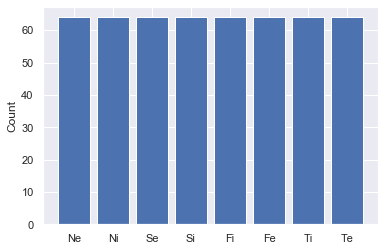

In [5]:
np.random.seed(20)
split = np.random.rand(dfd.shape[0])
train_df = resample_df(dfd,176)
test_df = pd.concat([dfd,train_df]).drop_duplicates(keep=False)

print(f"Size of Training set: {len(train_df)}")
print(f"Size of Test set: {len(test_df)}")

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("\nGraph the test set distribution to ensure cognitive function balance is maintained")
columns_to_use = np.array(test_df.columns[2:10])
counts = test_df.iloc[:,2:10].apply(np.sum,axis=0)
plt.bar(columns_to_use,counts)
plt.ylabel("Count")

In [6]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
test_df = test_df.sample(frac=1).reset_index(drop=True)


# Cleaning the DF and Generating Structural Features

Originally each users posts are included in the data as one total string with each post separated by pipe 
characters.  We want to clean the dataframe and make sure that the posts are individually extracted for 
each user.

While doing this we want to extract structural variables (post length, words per sentence, etc), since 
these may prove to be helpful indicators of specific cogntive functions.

In [7]:
import re
from collections import Counter 
from string import punctuation
import nltk
nltk.download('punkt')
import nltk.tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize

#Clean the users posts 
def clean_posts(df,index,sample_format):
    # Split the users posts into separate posts
    # Enters this branch if we test a sample post (later on)
    
    #check if df is the df that we test on our sample text which has a different format than forum texts 
    if(sample_format == 1):
        posts_list = [df['joined'][index]]
    else:
        posts_list = df['posts'][index].split('|||')
    
    
    # Create the variables to be used later
    words_per_post = []
    length_of_post = []
    sentences_per_post = []
    words_per_sent = []
    posts = []
    #Iterate through each post
    for count,post in enumerate(posts_list):
        # Get structural vars
        if(len(post) > 0):
            posts.append(post)
            length_of_post.append(len(post))
            words_per_post.append(len(word_tokenize(post)))
            sentences_per_post.append(len(sent_tokenize(post)))
            words_per_sent_temp = []
            for s in sent_tokenize(post):
                words = word_tokenize(s)
                words_per_sent_temp.append(len(words))
            words_per_sent.append(np.mean(words_per_sent_temp))
        else:
            count -= 1
    return [posts, np.mean(length_of_post), np.mean(words_per_post), np.mean(sentences_per_post), np.mean(words_per_sent)]



train_post_list = []
train_avg_post_length = []
train_words_per_post = []
train_sents_per_post = []
train_words_per_sent = []


for row in train_df.iterrows():
    cleaned_posts = clean_posts(train_df,row[0],0)
    train_post_list.append(cleaned_posts[0])
    train_avg_post_length.append(cleaned_posts[1])
    train_words_per_post.append(cleaned_posts[2])
    train_sents_per_post.append(cleaned_posts[3])
    train_words_per_sent.append(cleaned_posts[4])

train_df['post_list'] = train_post_list
train_df['avg_post_length'] = train_avg_post_length
train_df['words_per_post'] = train_words_per_post
train_df['sents_per_post'] = train_sents_per_post
train_df['words_per_sent'] = train_words_per_sent


test_post_list = []
test_avg_post_length = []
test_words_per_post = []
test_sents_per_post = []
test_words_per_sent = []

for row in test_df.iterrows():
    cleaned_posts = clean_posts(test_df,row[0],0)
    test_post_list.append(cleaned_posts[0])
    test_avg_post_length.append(cleaned_posts[1])
    test_words_per_post.append(cleaned_posts[2])
    test_sents_per_post.append(cleaned_posts[3])
    test_words_per_sent.append(cleaned_posts[4])


test_df['post_list'] = test_post_list
test_df['avg_post_length'] = test_avg_post_length
test_df['words_per_post'] = test_words_per_post
test_df['sents_per_post'] = test_sents_per_post
test_df['words_per_sent'] = test_words_per_sent


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/allanporter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Join all of a single users posts into a single string to make extracting certain variables more readable

In [8]:
def join_posts(df,attr):
    joined = []
    for row in df.iterrows():
        joined_row = ''
        for post in row[1][attr]:
            joined_row = joined_row + post
        joined.append(joined_row)
    return joined
train_df['joined'] = join_posts(train_df,'post_list')
test_df['joined'] = join_posts(test_df,'post_list')

# Clean words that relate only to personality to better generalize data

These words that relate to only personality will bias our data if included.  For Example- People who write "Fi" are more
likely to possess the FI cogntive function.  

Note that if we were predicting cogntive function for only people who post on a personality forum these may 
end up being valid predictors of personality.  But the goal here is to generalize our prediction
as much as possible to other text as well.  

I also included www, youtube and iphone in this list of words to remove as I saw that they all came up
very often throughout users posts but were highly correlated with links posted (www, youtube) and
"sent from my iphone" (iphone) notifications.  

In [9]:
to_remove = ['mbti','www','infps','infjs','isfps','isfjs','enfps','enfjs','entjs','intjs','estps','estjs','istps','istjs',
             'iphone','youtub','infp','infj','intp','intj','entp','enfp','entj','enfj','isfp','isfj','esfj','esfp','estj','estp','istp','istj','fi','fe','ti','te','si','se','ni','ne']

def clean_join(df):
    for row in df.iterrows():
        joined = row[1]['joined']
        for word in to_remove:
            #while(word in joined):
            joined.replace(word,'')
clean_join(train_df)
clean_join(test_df)

# Generating Punctuation, Link and Media Features

Use of punctuation, posting links and posting different types of media (images, videos) may prove to be
predictors of cogntive function so will be added to our dataframe as potential features. 

In [10]:
def get_more_vars(df):
    
    question_count = []
    exclamation_count = []
    comma_count = []
    link_count = []
    words_per_sent = []
    image_count = []
    video_count = []
    nonmedia_url_count = []

    for row in df.iterrows():
        posts = row[1]['joined']
        length = len(posts)
        comma_count.append(posts.count(',') / length)
        question_count.append(posts.count('?') / length)
        exclamation_count.append(posts.count('!') / length)
        sentences = sent_tokenize(posts)
        temp_sent = []
            
        links = re.findall('(https?://[^\s]+)', posts)
        link_count.append(len(links) / length)
        images = 0
        videos = 0
        non_media_url = 0
        for l in links:
            if 'jpg' in l or 'png' in l:
                images += 1
            elif 'youtube' in l:
                videos += 1
            else:
                non_media_url += 1
        image_count.append(images / length)
        video_count.append(videos / length)
        nonmedia_url_count.append(non_media_url / length)
    return [question_count, exclamation_count, comma_count, link_count, image_count, video_count, nonmedia_url_count]

more_vars = get_more_vars(train_df)
train_df['question_count'] = more_vars[0]
train_df['exclamation_count'] = more_vars[1]
train_df['comma_count'] = more_vars[2]
train_df['link_count'] = more_vars[3]
train_df['image_count'] = more_vars[4]
train_df['video_count'] = more_vars[5]
train_df['nonmedia_url_count'] = more_vars[6]

more_vars_d = get_more_vars(test_df)
test_df['question_count'] = more_vars_d[0]
test_df['exclamation_count'] = more_vars_d[1]
test_df['comma_count'] = more_vars_d[2]
test_df['link_count'] = more_vars_d[3]
test_df['image_count'] = more_vars_d[4]
test_df['video_count'] = more_vars_d[5]
test_df['nonmedia_url_count'] = more_vars_d[6]

# Dropping Features that are no longer needed

In [11]:
def drop_irrelevant(df):
    df = df.dropna()
    df = df.drop(columns=["posts","type"])
    df = df.drop(columns=['SFP','SFJ','STJ','STP','NFP','NFJ','NTP','NTJ'])
    return df
train_df = drop_irrelevant(train_df)
test_df = drop_irrelevant(test_df)

# Check for Missing Values 


In [12]:
train_df.isnull().values.any()

False

None found

# Check Distributions of Media and Punctuation Variables and Find Outliers

Note that when I first checked these distributions there were some major outliers which had to do
with how I joined the post data earlier.  Ive since corrected such mistakes and few significant outliers are now
found.  The ones that are found were checked and found to be valid data values. 

In [13]:
media_and_punc = 'video_count','image_count','nonmedia_url_count','question_count', 'exclamation_count', 'comma_count'
to_plot = []
[to_plot.append(train_df[col]) for col in media_and_punc]
media_punc_df = pd.DataFrame(to_plot).transpose()
media_punc_df.head()

,video_count,image_count,nonmedia_url_count,question_count,exclamation_count,comma_count
0,0.000000,0.000129,0.0,0.000772,0.003987,0.014148
1,0.000000,0.000000,0.0,0.000698,0.000349,0.007213
2,0.000502,0.000000,0.0,0.001338,0.000836,0.009535
3,0.000204,0.000000,0.0,0.002043,0.000000,0.007560
4,0.000000,0.000000,0.0,0.002774,0.000000,0.001525


# Use Scatter Plots to Visualize the Distributions

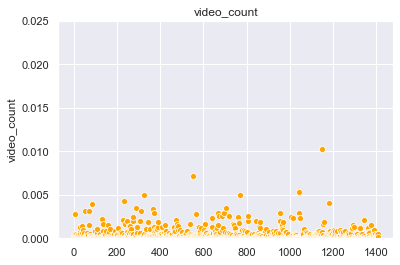

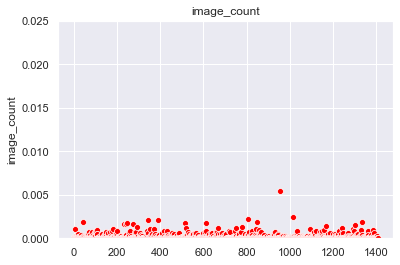

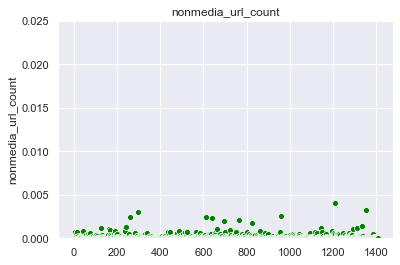

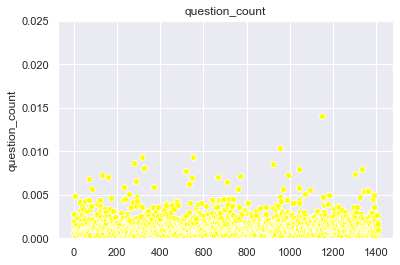

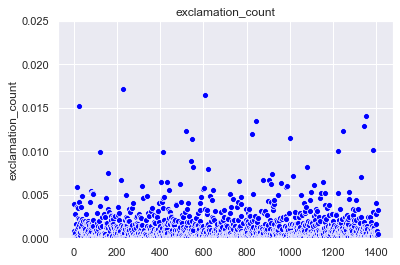

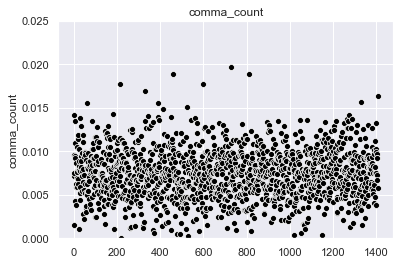

In [14]:
colors = ['orange','red','green','yellow', 'blue','black']
i=0
for col in media_and_punc:
    plt.figure(figsize=(6,4))
    plt.title(col)
    plt.ylim(0,.025)
    sb.scatterplot(range(len(train_df)),train_df[col],color=colors[i])
    i+=1

# Analyze the distribution of the structural variables

In [15]:
structural = 'avg_post_length','words_per_post','sents_per_post','words_per_sent'
to_plot = []
[to_plot.append(train_df[col]) for col in structural]
structural_df = pd.DataFrame(to_plot).transpose()
structural_df.head()

,avg_post_length,words_per_post,sents_per_post,words_per_sent
0,155.500000,34.600000,2.5000,13.997000
1,179.083333,38.895833,2.9375,15.081597
2,119.560000,26.200000,2.0600,13.158333
3,143.941176,30.970588,2.0000,18.382353
4,144.220000,34.400000,3.2000,11.974286


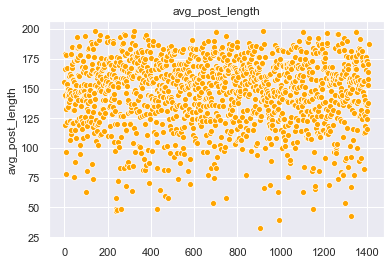

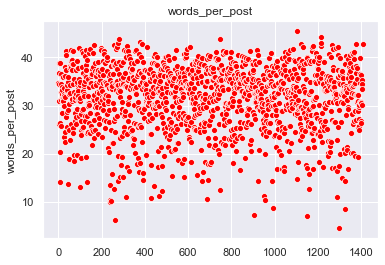

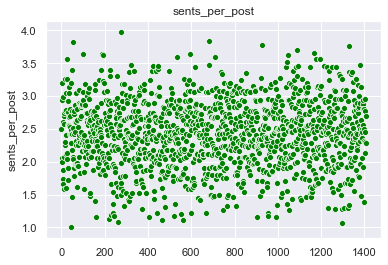

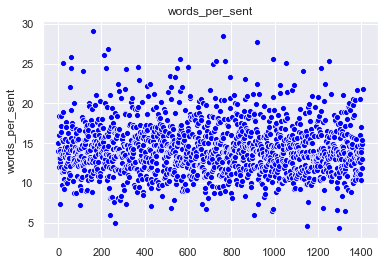

In [16]:
colors = ['orange','red','green', 'blue']
i=0
for col in structural:
    plt.figure(figsize=(6,4))
    plt.title(col)
    plt.xlabel = "user"
    sb.scatterplot(range(len(train_df)),train_df[col],color=colors[i])
    i+=1

# Correlating Non Word Variables with Cognitive Function

In [17]:
# drop non numeric features
nonwords = train_df.drop(['post_list','joined'],axis=1)

In [18]:
#get nonword features
non_functions = [col for col in nonwords.columns if len(col) > 2]
nonwords = nonwords.loc[:,non_functions]

In [19]:
#calculate correlations
cog_functions = [col for col in train_df.columns if len(col) == 2]
functions = train_df.loc[:,cog_functions]
corr_list = []
for func in cog_functions:
    print(f"\nCorrelations between {func} and Nonword Variables\n")
    print(nonwords.corrwith(train_df[func]))
    listed = nonwords.corrwith(train_df[func])
    count = 0
    for row in listed:
        attribute = listed.index[count]
        correlation = row
        corr_list.append([func,attribute,correlation])
        count+=1



Correlations between Ne and Nonword Variables

avg_post_length       0.036388
words_per_post        0.019061
sents_per_post       -0.021317
words_per_sent        0.053554
question_count       -0.024123
exclamation_count     0.011685
comma_count           0.062474
link_count           -0.025243
image_count           0.001580
video_count          -0.020650
nonmedia_url_count   -0.031970
dtype: float64

Correlations between Ni and Nonword Variables

avg_post_length       0.034877
words_per_post        0.016578
sents_per_post       -0.001360
words_per_sent        0.032956
question_count       -0.014113
exclamation_count    -0.028697
comma_count          -0.036428
link_count           -0.013435
image_count           0.011288
video_count          -0.033500
nonmedia_url_count    0.024851
dtype: float64

Correlations between Se and Nonword Variables

avg_post_length      -0.093675
words_per_post       -0.077151
sents_per_post       -0.004203
words_per_sent       -0.096827
question_count      

In [20]:
func_nonword_corrs = pd.DataFrame(corr_list,columns=["Function","Attribute","Correlation"])
func_nonword_corrs = func_nonword_corrs.sort_values(by="Correlation", ascending=False)
print("Top Correlations between Cognitive Functions and Nonword Attributes")
func_nonword_corrs.head(10)

Top Correlations between Cognitive Functions and Nonword Attributes


,Function,Attribute,Correlation
49,Fi,exclamation_count,0.164775
56,Fe,words_per_post,0.079650
57,Fe,sents_per_post,0.077336
60,Fe,exclamation_count,0.071209
26,Se,question_count,0.067171
55,Fe,avg_post_length,0.066956
6,Ne,comma_count,0.062474
29,Se,link_count,0.061871
31,Se,video_count,0.057485
3,Ne,words_per_sent,0.053554


It seems like structural,media and punctuation variables for the most part arent correlated highly with
jungian cognitive function.  The somewhat exception is "exclamation count" which seems mildly correlated
with the Fi cogntive function.  Perhaps judgers who internalize their judgments of the world through
their feelings are more likely to use exclamation points.  Interesting, but not exactly what were looking for.
Lets look at if words the posters used can act as a better indicator of cognitive function.  

# Generate a list of all the words used per row

Now its time to start thinking about the word features.  While we will be using a vectorizer to
form word features, manually generating a list of words used per user will be important in checking
specific instances of words to better understand our data first hand.  

In [21]:
import string

def wordlist(df):
    wordlist = []
    for row in df.iterrows():
        posts = row[1]['joined']
        posts = posts.lower()
        table = str.maketrans(dict.fromkeys(string.punctuation)) 
        posts = posts.translate(table)                          
        wordlist.append(posts.split(' '))
        to_remove.append('')
        for word in to_remove: 
            while(word in wordlist):
                wordlist.remove(word)
    return wordlist
train_df['word_list'] = wordlist(train_df)
test_df['word_list'] = wordlist(test_df)

# Generate a Function to check the Users Instances of a word or words 

Being able to check how often a user uses a certain word may prove to be valuable during data exploration when we
individually test certain words to see if they relate to specific cognitive functions.

In [22]:
def check_instance(df,target):
    list_of_instances = []
    for row in df.iterrows():
        instance = 0
        for word in row[1]['word_list']:
            if word in target:
                instance += 1
        instance_count = instance / len(row[1]['word_list'])
        list_of_instances.append(instance_count)
    return list_of_instances

# Data Exploration with Words

Here we will start to explore the instances of words in the dataset, we first need to remove empty strings
and prepare our word lists for each user for further analysis.

In [23]:
def remove_empty(df):
    for row in df.iterrows():
        wordlist = row[1]['word_list']
        while '' in wordlist:
            wordlist.remove('')
        row[1]['word_list'] = wordlist
remove_empty(train_df)


def get_all_words(df,t):
    if t != 'all':
        df = train_df[df[t] == 1]
    all_words = []
    for row in df.iterrows():
        all_words = all_words + (row[1]['word_list'])
    return all_words

# Generate a list of the top words associated with each cogntive function

Here we will show the top words associated with each cognitive function.  Note that most top words will be
the same for all users throughout all cognitive functions.  Though since stop words could
potentially be indicators of cognitive function, we will not remove them.

In [24]:


def get_top_words(t,ng):
    type_written = t[:-2]
    length_t = len(t)
    if(ng == 1):
        word_count = Counter(t).most_common()
    else:
        word_count = Counter(ngrams(t, ng)).most_common()
    instances = []
    for word in list(word_count):
        instance = word[1] / length_t
        instances.append([word[0],instance])
    return instances
all_words = get_all_words(train_df,'all')
all_fi = get_all_words(train_df,'Fi')
all_fe = get_all_words(train_df,'Fe')
all_ti = get_all_words(train_df,'Ti')
all_te = get_all_words(train_df,'Te')
all_si = get_all_words(train_df,'Si')
all_se = get_all_words(train_df,'Se')
all_ni = get_all_words(train_df,'Ni')
all_ne = get_all_words(train_df,'Ne')
types_to_plot = [all_words,all_fi,all_fe,all_te,all_ti,all_si,all_se,all_ni,all_ne]
list_of_types = []
for t in types_to_plot:
    all_words = get_top_words(t,1) 
    list_of_types.append(all_words)

Most popular words associated with each cogntive function


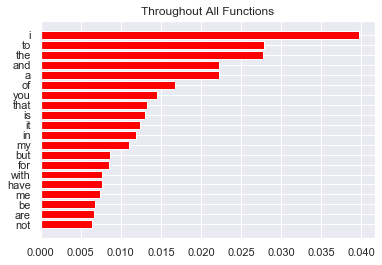

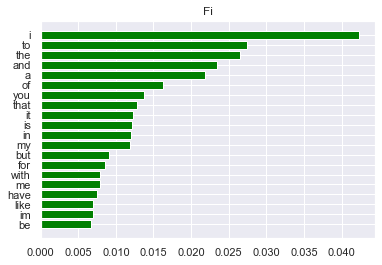

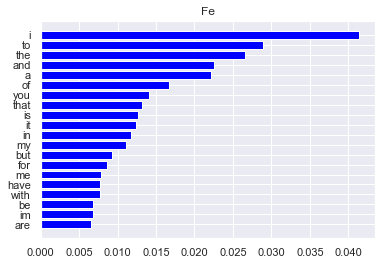

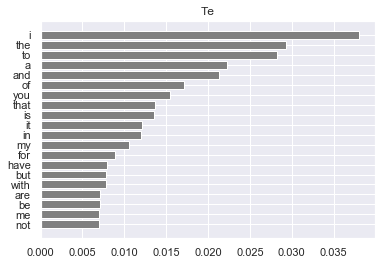

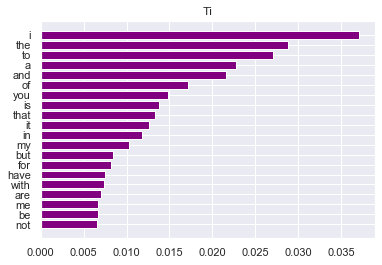

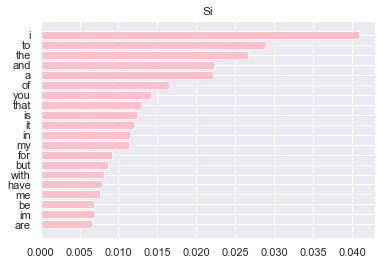

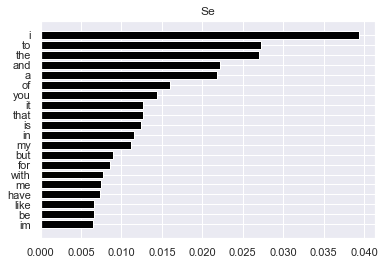

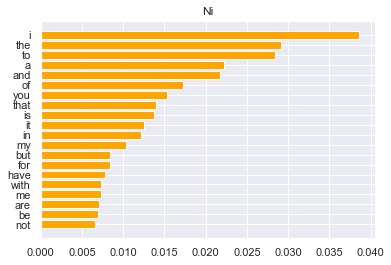

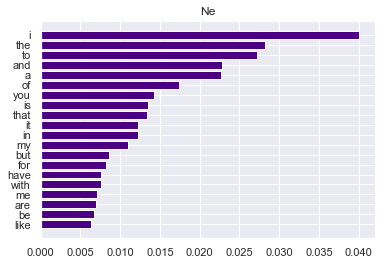

In [25]:
types_to_plot = [all_fi,all_fe,all_te,all_ti,all_si,all_se,all_ni,all_ne]
def plot_topwords():
    counter = 0
    colors = ['red','green','blue','gray','purple','pink','black','orange','indigo']
    titles = ['Throughout All Functions','Fi','Fe','Te','Ti','Si','Se','Ni','Ne']
    print("Most popular words associated with each cogntive function")
    for t in list_of_types:
        words = [i[0] for i in t[:20]]
        counts =[i[1] for i in t[:20]]
        fig = plt.figure()
        wc_df = pd.DataFrame(counts,words,columns=["counts"])
        to_plot = wc_df.sort_values(by="counts",ascending=True)
        plt.barh(to_plot.index,to_plot.counts,color=colors[counter])
        plt.title(titles[counter])
        counter+=1
plot_topwords()

Lets start to analyze the most popular bigrams used by users as well

In [26]:
from itertools import tee, islice
def ngrams(words, n):
    while 1:
        x,y = tee(words)
        slices = tuple(islice(x, n))
        if len(slices) == n:
            yield slices
            next(y)
            words = y
        else:
            break



def get_ngrams(n):
    ngrams_list = []
    for t in types_to_plot:
        word_count = Counter(ngrams(t, n)).most_common()
        key1 = [str(w[0][0]) for w in word_count]
        vals = [w[1] / len(word_count) for w in word_count]
        key2 = [str(w[0][1]) for w in word_count]
        if n >= 3:
            key3 = [str(w[0][2]) for w in word_count]
        if n == 4:
            key4 = [str(w[0][3]) for w in word_count]
        if n==2:
            ind = [x+' ' +y for x,y in zip(key1,key2)]
        elif n==3:
            ind = [x + ' ' + y + ' ' + z for x,y,z in zip(key1,key2,key3)]
        elif n == 4:
            ind = [x + ' ' + y + ' ' + z + ' ' + w for x,y,z,w in zip(key1,key2,key3,key4)]
        ng_df = pd.DataFrame(vals,ind,columns=['counts'])
        to_plot = ng_df.sort_values(by='counts',ascending=False)
        ngrams_list.append(to_plot)
    return ngrams_list
list_ngrams = get_ngrams(2)

# Observe the Top 10 Bigrams associated with each Cognitive Function

In [27]:
c = 0
titles = ['All Words','Fi','Fe','Te','Ti','Si','Se','Ni','Ne']

print("Top 10 Bigrams associated with each cogntive function\n")
for bg in list_ngrams:
    bigrams = list_ngrams[c]
    print(f'{titles[c]}: Top 10 Bigrams\n')
    print(bigrams.head(10))
    print('\n')
    c+=1

Top 10 Bigrams associated with each cogntive function

All Words: Top 10 Bigrams

           counts
i dont   0.005583
to be    0.005360
and i    0.005297
i have   0.005286
i think  0.005064
i was    0.005042
but i    0.005000
in the   0.004836
of the   0.004661
i am     0.004544


Fi: Top 10 Bigrams

           counts
to be    0.006181
i dont   0.005430
i have   0.005331
but i    0.005170
of the   0.005102
i think  0.004993
i am     0.004810
and i    0.004810
i was    0.004654
in the   0.004508


Fe: Top 10 Bigrams

          counts
to be   0.005680
i have  0.005324
of the  0.005251
i dont  0.005021
in the  0.004869
i am    0.004450
i was   0.004262
but i   0.004047
and i   0.003864
that i  0.003639


Te: Top 10 Bigrams

           counts
to be    0.005019
i dont   0.004988
of the   0.004725
in the   0.004540
i have   0.004360
i was    0.004195
but i    0.004035
i am     0.004030
i think  0.003829
and i    0.003659


Ti: Top 10 Bigrams

           counts
to be    0.006087
i dont   0.00

Now lets begin to think about how we will prepare word features for modeling.  We will have to vectorize
them first.

# Use Vectorizers to generate word features

We will try using both countvectorizers and tfidfvectorizers and see which better model the word features for
machine learning

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             ngram_range=(1,4),
                             stop_words=to_remove,  
                             binary=True
                             )
cv.fit(train_df.joined)
X_train_cv  = cv.transform(train_df.joined)
X_test_cv = cv.transform(test_df.joined)

In [29]:
tf = TfidfVectorizer(analyzer="word", 
                             max_features=1500, 
                             tokenizer=None,    
                             preprocessor=None, 
                             ngram_range=(1,4),
                             stop_words=to_remove,  
                             binary=True
                             )
tf.fit(train_df.joined)
X_train_tf  = tf.transform(train_df.joined)
X_test_tf = tf.transform(test_df.joined)

Create both matrix and dataframe formats for the vectors

In [30]:
X_train_tf_matrix = X_train_tf
X_test_tf_matrix = X_test_tf
X_train_cv_matrix = X_train_cv
X_test_cv_matrix = X_test_cv

In [31]:
X_train_cv = pd.DataFrame(X_train_cv_matrix.toarray())
X_test_cv = pd.DataFrame(X_test_cv_matrix.toarray())
X_train_tf = pd.DataFrame(X_train_tf_matrix.toarray())
X_test_tf = pd.DataFrame(X_test_tf_matrix.toarray())

Lets output some feature names to make sure its working

In [32]:
tf.get_feature_names()[10:20]

['about the',
 'about this',
 'about what',
 'above',
 'absolutely',
 'accept',
 'accurate',
 'across',
 'act',
 'action']

# Generate A Method to Reduce Dimensionality

Many Models work better with independent features and the vectorized features surely
include levels of redundance.  TSVD will be used for dimensionality reduction.

In [33]:
from sklearn.decomposition import TruncatedSVD

def reduce_dimensionality(cv,training_df,testing_df):
    if(cv == "cv"):
        tsvd_cv = TruncatedSVD(n_components=100, 
                           n_iter=10, 
                           random_state=42)
        tsvd_cv.fit(training_df)
        train = tsvd_cv.transform(training_df)
        test = tsvd_cv.transform(testing_df)
        return [train,test]
        
    elif(cv == "tfidf"):
        tsvd_tf = TruncatedSVD(n_components=100, 
                           n_iter=10, 
                           random_state=42)
        tsvd_tf.fit(training_df)
        train = tsvd_tf.transform(training_df)
        test = tsvd_tf.transform(testing_df)
        return [train,test]


# Generate A Method to Build a Classifier, Predict a target and Render Evaluations

Now lets start actually modeling.  Creating a "Classify" function that could be fine tuned to try and classify
cognitive functions per a set of nonword features will be our first step.  Note how there is an option for "singular"
use of the classifier.  If the "singular" param is set, then only one cognitive function will be judged at a 
time and tried for each type of classifier in our list. If it is not set, all cognitive functions will be 
modelled for by a hyperparameter tuned random forest classifier.


In [34]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, SGDRegressor
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, AdaBoostRegressor
from sklearn.model_selection import cross_validate,StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, f1_score, auc, confusion_matrix,precision_recall_curve, mean_squared_error
from sklearn.tree import DecisionTreeClassifier

# identify list of cognitive function types
type_list = ['Fi','Fe','Ti','Te','Ni','Ne','Si','Se']


In [35]:
def classify(X_train,X_test,scaled,tsvd,singular,func,gs):
    original_X_train = X_train
    original_X_test = X_test
    feat_names = X_train.columns
    
    models = [
        DummyClassifier(random_state=42),
        RandomForestClassifier(random_state=42),
        AdaBoostClassifier(random_state=42),
        GaussianNB(),
        SGDClassifier(random_state=42,loss='log'),
        LogisticRegression()
    ]
    
    clf_names = ['Dummy','RF-Classifier','Ada Boost-Classifier',
                 'Gaussian Naive Bayes','SGD-Classifier','Logistic Regression']
    
    if(scaled == 1):
        sc = StandardScaler()
        sc.fit(X_train)
        X_train = sc.transform(X_train)
        X_test = sc.transform(X_test)
    if(tsvd == 1): 
        X_train,X_test = reduce_dimensionality('cv',X_train,X_test)
        
    aucs = []
    if(gs == 1):
        if(singular==0):
            for t in type_list:
                y_train = train_df[t]
                y_test = test_df[t]
                for estimator in [5,10,30,100]:
                    for depth in [3,5,10,20,50]:
                        model = RandomForestClassifier(n_estimators=estimator, max_depth = depth,random_state=10)
                        model.fit(X_train, y_train)
                        y_pred = model.predict(X_test)
                        predictions = [value for value in y_pred]
                        mse= mean_squared_error(y_test,y_pred) 
        

                        # evaluate predictions
                        accuracy = accuracy_score(y_test, predictions)
                        prec = precision_score(y_test, y_pred, average='macro')
                        f1 = f1_score(y_test, y_pred, average='macro')
                        mse= mean_squared_error(y_test,y_pred) 


                        aucs.append([t,estimator,depth,roc_auc_score(y_test,y_pred),accuracy,prec,f1,mse])

        elif(singular == 1):
            y_train = train_df[func]
            y_test = test_df[func]
            for estimator in [5,15,30]:
                for depth in [5,10,15]:
                    model = RandomForestClassifier(n_estimators=estimator, max_depth = depth,random_state=10)
                    model.fit(X_train, y_train)
                    # make predictions for test data
                    y_pred = model.predict(X_test)
                    predictions = [value for value in y_pred]
                    mse= mean_squared_error(y_test,y_pred) 

                    accuracy = accuracy_score(y_test, predictions)
                    prec = precision_score(y_test, y_pred, average='macro')
                    f1 = f1_score(y_test, y_pred, average='macro')
                    aucs.append([func,estimator,depth,roc_auc_score(y_test,y_pred),accuracy,prec,f1,mse])
        aucs = pd.DataFrame(aucs,columns=["Function","Est","Depth","AUC","Accuracy","Precision","F1","MSE"])
    else:
        count = 0
        y_train = train_df[func]
        y_test = test_df[func]
        for clf in models:
            classifier = clf_names[count]
            model = clf
            model.fit(X_train, y_train)
            try:
                y_pred = model.predict_proba(X_test)[:,1]
            except:
                y_pred = model.predict(X_test)
            predictions = [value for value in y_pred]
            mse= mean_squared_error(y_test,y_pred) 
            count+=1
            aucs.append([func,clf,roc_auc_score(y_test,y_pred),mse,classifier])
        aucs = pd.DataFrame(aucs,columns=["Function","Model","AUC","MSE","Classifier"])

    aucs = aucs.sort_values(by='AUC',ascending=False)
    return aucs


# Can Non Word Features Do a Good Job In Predicting Cognitive Functions?

Now lets try and test our classify function to see if non word features alone can be good predictors
of cognitive functions.  First we will try the hyperparameter tuned random forest approach
for all cogntive functions and then try the singular approach where we try multiple models
for each cognitive function.

In [36]:
nw_feats = ['sents_per_post','words_per_sent','exclamation_count','comma_count','question_count',
'video_count','image_count','nonmedia_url_count']

non_word_feats_train =train_df.loc[:,nw_feats]
non_word_feats_test=test_df.loc[:,nw_feats]

#group results by best AUC for each cognitive function
def group_by_function(df):
    count = 0
    length = len(df)
    best_df = pd.DataFrame(columns=df.columns)
    for f in type_list:
        grouped = df.loc[df['Function'] == f]
        grouped = grouped.sort_values(by='AUC',ascending=False)
        grouped = grouped.iloc[0]
        grouped = dict(grouped)
        best_df = best_df.append(grouped,ignore_index=True)
    best_df = best_df.sort_values(by='AUC',ascending=False)
    return best_df
        
        
# Try a Random Forest Classifier with Hyperparameter Tuning
nonwords_classified_rf = classify(non_word_feats_train,non_word_feats_test,1,0,0,'',1)
nonwords_classified_rf = group_by_function(nonwords_classified_rf)
print("Evaluating How Well Nonword features Predict Cognitive Functions via Random Forest Hyperparameter Tuning")
nonwords_classified_rf

Evaluating How Well Nonword features Predict Cognitive Functions via Random Forest Hyperparameter Tuning


,Function,Est,Depth,AUC,Accuracy,Precision,F1,MSE
1,Fe,100,20,0.546875,0.765625,0.734146,0.526101,0.234375
2,Ti,10,20,0.541667,0.734375,0.591954,0.533448,0.265625
6,Si,100,20,0.541667,0.757812,0.674863,0.521004,0.242188
7,Se,5,20,0.533854,0.730469,0.577626,0.522272,0.269531
0,Fi,5,10,0.528646,0.722656,0.560952,0.517199,0.277344
4,Ni,5,20,0.526042,0.710938,0.547198,0.517866,0.289062
5,Ne,5,10,0.523438,0.730469,0.563957,0.503918,0.269531
3,Te,30,20,0.510417,0.734375,0.543716,0.474650,0.265625


Lets try and use AUCs as our primary metric for evaluation since for by random chance each each user
has only a 25% chance of displaying a primary cognitive function of a certain type.  Therefore, if we 
just used accuracy, the model will simply look more accurate than it is since it will learn to guess
against the presence of the cogntive function in many cases and be right.  Instead the TPR and FPR will
give a better indication of how well our model is classifying the data. 

In [37]:
# Lets try implementing a classify function that tries a number of different models and sees which performs best

def classify_function(train,test):
    results_df = pd.DataFrame()
    for func in type_list:
        result = classify(train,test,0,0,1,func,0)
        results_df = pd.concat([results_df,result],axis=0)
        results_df.columns = result.columns
    results_df = results_df.sort_values(by='AUC',ascending=False)
    return results_df

nonwords_classified = classify_function(non_word_feats_train,non_word_feats_test)
print("Evaluating How Well Nonword features Predict Cognitive Functions Via Multiple Classifiers")
nonwords_classified = group_by_function(nonwords_classified)
nonwords_classified

Evaluating How Well Nonword features Predict Cognitive Functions Via Multiple Classifiers


,Function,Model,AUC,MSE,Classifier
4,Ni,"GaussianNB(priors=None, var_smoothing=1e-09)",0.606364,0.185918,Gaussian Naive Bayes
2,Ti,"(DecisionTreeClassifier(class_weight=None, cri...",0.582357,0.208437,RF-Classifier
7,Se,"GaussianNB(priors=None, var_smoothing=1e-09)",0.581380,0.208421,Gaussian Naive Bayes
6,Si,"(DecisionTreeClassifier(class_weight=None, cri...",0.571289,0.245544,Ada Boost-Classifier
1,Fe,"(DecisionTreeClassifier(class_weight=None, cri...",0.555135,0.203398,RF-Classifier
0,Fi,"GaussianNB(priors=None, var_smoothing=1e-09)",0.542969,0.211945,Gaussian Naive Bayes
5,Ne,"LogisticRegression(C=1.0, class_weight=None, d...",0.531413,0.187462,Logistic Regression
3,Te,"GaussianNB(priors=None, var_smoothing=1e-09)",0.528564,0.201020,Gaussian Naive Bayes


While this approach of iterating through different classifiers to see which model performs best does better, the AUCS are still pretty low.  Lets try using the word features from our vectorizers and see how they do.

# Generate a Function to Classify Cognitive Functions through vectorizers

Using vectorizers to classify cognitive functions will be different and requires a different 
type of classify function that we will entitle "evaluate".  We will take the word vectors, reduce
their dimensionalities and then try each classifier on them to see which performs best AUC wise.

In [38]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor

In [39]:
list_of_classifiers = [
    DummyClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    SGDClassifier(random_state=42,loss='log'),
    LogisticRegression()
    
]

from sklearn.metrics import log_loss

def evaluate():
    X_train_cv = X_train_cv_matrix
    X_test_cv = X_test_cv_matrix
    X_train_tf = X_train_cv_matrix
    X_test_tf = X_test_cv_matrix
    
    evaluation_list = []
    clf_names = ['Dummy','RF-Classifier','Ada Boost-Classifier',
                 'Gaussian Naive Bayes','SGD-Classifier','Logistic Regression']
    tf = 0
    for vect in ['tfidf','cv']:
        count=-1
        for clf in list_of_classifiers:
            count+=1
            for t in type_list:
                if(vect =='cv'):
                    X_train = X_train_cv
                    X_test = X_test_cv
                elif(vect == 'tfidf'):
                    X_train = X_train_tf
                    X_test = X_test_tf
                X_train,X_test = reduce_dimensionality(vect,X_train,X_test)
                y_train = train_df[t]
                y_test = test_df[t]
                model = clf
                model.fit(X_train, y_train)
                try:
                    y_pred = model.predict_proba(X_test)[:,1]
                except:
                    y_pred = model.predict(X_test)

                predictions = [value for value in y_pred]
                # evaluate predictions
                mse= mean_squared_error(y_test,y_pred) 
                fpr, tpr, thresholds = roc_curve(y_test, y_pred)


                
                
                evaluation_list.append([t,clf_names[count],vect,log_loss(y_test,y_pred,eps=1e-15),
                                        roc_auc_score(y_test, y_pred),mse,clf
                                        ])
    results_df = pd.DataFrame(evaluation_list,columns = ['Function','Classifier','Vectorizer','Logloss',
                                                        'AUC','MSE','Model'])
    results_df = results_df.sort_values(by='AUC',ascending=False)
    results_df.reset_index(drop=True)
    return results_df

Lets now see which classifiers perform the best in predicting cognitive functions via vectorized features

(This may take a minute or two to run)

In [40]:
vectorized_classified = evaluate()
print("Evaluating How Well Word features Predict Cognitive Functions Via Multiple Classifiers")
vectorized_classified = group_by_function(vectorized_classified)
vectorized_classified

Evaluating How Well Word features Predict Cognitive Functions Via Multiple Classifiers


,Function,Classifier,Vectorizer,Logloss,AUC,MSE,Model
3,Te,SGD-Classifier,tfidf,1.649564,0.716960,0.277686,"SGDClassifier(alpha=0.0001, average=False, cla..."
0,Fi,Logistic Regression,cv,0.514910,0.702230,0.169336,"LogisticRegression(C=1.0, class_weight=None, d..."
7,Se,Logistic Regression,tfidf,0.528768,0.682454,0.176746,"LogisticRegression(C=1.0, class_weight=None, d..."
2,Ti,SGD-Classifier,tfidf,1.116341,0.672607,0.221785,"SGDClassifier(alpha=0.0001, average=False, cla..."
1,Fe,RF-Classifier,cv,1.527491,0.672363,0.183711,"(DecisionTreeClassifier(class_weight=None, cri..."
6,Si,RF-Classifier,tfidf,1.180750,0.645996,0.190547,"(DecisionTreeClassifier(class_weight=None, cri..."
4,Ni,SGD-Classifier,tfidf,2.155907,0.597819,0.239449,"SGDClassifier(alpha=0.0001, average=False, cla..."
5,Ne,Logistic Regression,cv,0.581340,0.563802,0.191294,"LogisticRegression(C=1.0, class_weight=None, d..."


As seen above, vectorized word features do a much better job of classifying cognitive functions (High 60s-Low 70s Aucs).
That being said, lets see if we can do even better if we combine both vectorized word features and 
non word features in one model.

# Try Combining NonWordFeatures and VectorizedFeatures  

In [41]:
reduced_cv_train_matrix,reduced_cv_test_matrix = reduce_dimensionality('cv',X_train_cv_matrix,X_test_cv_matrix)


In [42]:
reduced_cv_train_matrix = pd.DataFrame(reduced_cv_train_matrix)
reduced_cv_test_matrix = pd.DataFrame(reduced_cv_test_matrix)

In [43]:
sc = StandardScaler()
scaled_nonwords_train = sc.fit_transform(non_word_feats_train)
scaled_nonwords_test = sc.fit_transform(non_word_feats_test)

In [44]:
scaled_nonwords_train = pd.DataFrame(scaled_nonwords_train)
scaled_nonwords_test = pd.DataFrame(scaled_nonwords_test)

In [45]:
combined_train_cv = pd.concat([reduced_cv_train_matrix,scaled_nonwords_train],axis=1)
combined_test_cv = pd.concat([reduced_cv_test_matrix,scaled_nonwords_test],axis=1)


In [46]:
combined = classify_function(combined_train_cv,combined_test_cv)
print("Evaluating How Well Nonword features and Word Features Combined Predict Cognitive Functions Via Multiple Classifiers")
combined = group_by_function(combined)
combined

Evaluating How Well Nonword features and Word Features Combined Predict Cognitive Functions Via Multiple Classifiers


,Function,Model,AUC,MSE,Classifier
0,Fi,"LogisticRegression(C=1.0, class_weight=None, d...",0.713623,0.170625,Logistic Regression
7,Se,"LogisticRegression(C=1.0, class_weight=None, d...",0.680664,0.176616,Logistic Regression
3,Te,"LogisticRegression(C=1.0, class_weight=None, d...",0.680257,0.175533,Logistic Regression
2,Ti,"LogisticRegression(C=1.0, class_weight=None, d...",0.668457,0.178748,Logistic Regression
1,Fe,"LogisticRegression(C=1.0, class_weight=None, d...",0.645589,0.175364,Logistic Regression
6,Si,"LogisticRegression(C=1.0, class_weight=None, d...",0.633057,0.183907,Logistic Regression
4,Ni,"GaussianNB(priors=None, var_smoothing=1e-09)",0.623454,0.189217,Gaussian Naive Bayes
5,Ne,"(DecisionTreeClassifier(class_weight=None, cri...",0.598145,0.204492,RF-Classifier


It seems that combining vectorized features with nonword features doesn't signficantly change our
results.

# Formulating Word Groups

Now lets try and form word groups that we intuitively associate with these cognitive functions and see if users
instances of words that belong to predefined certain groups can help predict cogntive functions.  Note that
these word groups are based off types of words that we thought could intuitively be associated with individual cognitive functions.  

Define the groups

In [47]:


''' Pehaps people who speak more in the first person possess different cognitive functions compared to those who
speak more in the second or third person. '''

second_person_words = ['you','youll','youve','youre','your','yours','youd','yourself']
first_person_singular = ['i','im','id','ill','ive','my','mine','myself']
third_person_singular = ['him','her','he','she','hes','hed','shed','shes','shell','shes','hell']
third_person_plural = ['theyll','theyve','theyd','theyre','them','their','they']
first_person_plural = ['us','we','well','weve','wed','were','our','ourselves']

'''Use of slang may be a good indicator of certain cognitive functions'''

whats_up = ['sup','whatsup','watsup']
laugh = ['lol','lmao','haha','aha','ha','rofl']

'''Family references'''
family = ['sister','brother','mom','mother','dad','father','uncle','aunt','grandfather','grandmother',
          'grandma','grandpa','grampa'
         
         ]

hi = ['hi','hello']
like = ['like']

perhaps = ['perhaps','indeed']

omg = ['omg']
'''Slang nicknames '''

nicknames = ['dude','bro','yo']

''' Shortened words'''

shortened = ['gnite','nite','ya','brb','ttyl','fr','k','kk','def','gm','gn']

socialmedia = ['facebook','twitter','instagram','pinterest','tumblr','youtube']

childhood = ['child','kid','childhood','nostalgia','nostalgic']

thinking = ['thought','think','thinks','thinking']

feeling = ['felt','feel', 'feeling','feels']

love = ['love','loved','lover','loving','loves']       

optimism = ['beautiful','great','awesome','best','wonderful']

pessimism = ['worst','sucks','hate','hated','suck','terrible']

elongate = ['very','really']

longing = ['wish','wished','wishing','hope','hoping','hoped','hopes','wishes']

loneliness = ['lonely','loneliness','alone','loner','loneliest']

wonder = ['wonder','wondering','wondered','wonders']

imagination = ['imagined','imagine','imagining','imagination']

friends = ['friend','friends']

In [48]:
word_groups = [first_person_singular,first_person_plural,second_person_words,
               third_person_singular,third_person_plural,whats_up,hi,laugh,family,like,perhaps,
               nicknames,shortened,socialmedia,childhood,thinking,feeling,love,optimism,
               pessimism,elongate,longing,loneliness,wonder,imagination,friends       
              ]
column_names = ['first_person_singular','first_person_plural','second_person_words',
               'third_person_singular','third_person_plural','whats_up','hi','laugh','family','like','perhaps',
               'nicknames','shortened','socialmedia','childhood','thinking','feeling','love','optimism',
               'pessimism','elongate','longing','loneliness','wonder','imagination','friends'
              ]

def get_group(df,group):
    group_feat = []
    for row in df.iterrows():
        instances = 0
        for word in row[1]['word_list']:
            if(word in group):
                instances+=1
        group_feat.append(instances / len(row[1]['word_list']))
    return group_feat
                
                
        
def add_word_group_feats(df):
    feature_list = []
    for group in word_groups:
        column = get_group(df,group)
        feature_list.append(column)
    feature_df = pd.DataFrame(feature_list)
    feature_df = feature_df.transpose()
    feature_df.columns = column_names
    result_df = feature_df
    return result_df
        
        
word_groups_train_df = add_word_group_feats(train_df)
word_groups_test_df = add_word_group_feats(test_df)

Now that we have our word groups lets try and view the top correlations between each of the word groups and each cognitive function

In [49]:
funcs = train_df.loc[:,type_list]

corr_list_groups = []
for func in type_list:
    listed = word_groups_train_df.corrwith(train_df[func])
    count = 0
    for row in listed:
        attribute = listed.index[count]
        correlation = row
        corr_list_groups.append([func,attribute,correlation])
        count+=1
print("Top Correlations between Cognitive Functions and Word Groups")
wordgroups_corrs = pd.DataFrame(corr_list_groups,columns=['Function','Attribute','Correlation'])
wordgroups_corrs = wordgroups_corrs.sort_values(by='Correlation',ascending=False)
wordgroups_corrs.head(10)


Top Correlations between Cognitive Functions and Word Groups


,Function,Attribute,Correlation
16,Fi,feeling,0.198818
17,Fi,love,0.189030
0,Fi,first_person_singular,0.150736
20,Fi,elongate,0.148017
9,Fi,like,0.122689
42,Fe,feeling,0.116272
46,Fe,elongate,0.101959
26,Fe,first_person_singular,0.097332
32,Fe,hi,0.089185
43,Fe,love,0.088493


Wow! not exactly surprising but it seems that people who possess introverted feeling
tend to slighly use words that relate to "feeling" or "love" more.  While the correlation
isnt too significant this is still definitely interesting!

Now lets plug our word group features into the classify function and see how well they do in
predicting cognitive functions

In [50]:
word_groups_classified = classify_function(word_groups_train_df,word_groups_test_df)
word_groups_classified = group_by_function(word_groups_classified)
word_groups_classified

,Function,Model,AUC,MSE,Classifier
0,Fi,"GaussianNB(priors=None, var_smoothing=1e-09)",0.653239,0.239120,Gaussian Naive Bayes
1,Fe,"SGDClassifier(alpha=0.0001, average=False, cla...",0.641276,0.185288,SGD-Classifier
3,Te,"GaussianNB(priors=None, var_smoothing=1e-09)",0.629883,0.582939,Gaussian Naive Bayes
2,Ti,"(DecisionTreeClassifier(class_weight=None, cri...",0.626343,0.239947,Ada Boost-Classifier
5,Ne,"GaussianNB(priors=None, var_smoothing=1e-09)",0.608805,0.194637,Gaussian Naive Bayes
7,Se,"GaussianNB(priors=None, var_smoothing=1e-09)",0.598877,0.252145,Gaussian Naive Bayes
6,Si,"SGDClassifier(alpha=0.0001, average=False, cla...",0.566895,0.189572,SGD-Classifier
4,Ni,"(DecisionTreeClassifier(class_weight=None, cri...",0.565308,0.199062,RF-Classifier


While word groups don't do as well as vectorized words for features they still exhibit some pretty good results.
Lets try and combine word groups and our other features to see if we can improve our results

# Try Combining Word Groups with other Features

Now lets try combining word group features and non word features and see how that can classify

In [51]:
wg_nw_train = pd.concat([word_groups_train_df,non_word_feats_train],axis=1)
wg_nw_test = pd.concat([word_groups_test_df,non_word_feats_test],axis=1)
print("Combining Non Word Features and Word Groups to Classify Cognitive Functions")
wg_nw_classified = classify_function(wg_nw_train,wg_nw_test)
wg_nw_classified = group_by_function(wg_nw_classified)
wg_nw_classified


Combining Non Word Features and Word Groups to Classify Cognitive Functions


,Function,Model,AUC,MSE,Classifier
2,Ti,"(DecisionTreeClassifier(class_weight=None, cri...",0.645915,0.243444,Ada Boost-Classifier
0,Fi,"GaussianNB(priors=None, var_smoothing=1e-09)",0.643962,0.237958,Gaussian Naive Bayes
3,Te,"GaussianNB(priors=None, var_smoothing=1e-09)",0.625244,0.253856,Gaussian Naive Bayes
5,Ne,"GaussianNB(priors=None, var_smoothing=1e-09)",0.604492,0.290476,Gaussian Naive Bayes
7,Se,"GaussianNB(priors=None, var_smoothing=1e-09)",0.599935,0.243038,Gaussian Naive Bayes
1,Fe,"(DecisionTreeClassifier(class_weight=None, cri...",0.598063,0.245606,Ada Boost-Classifier
6,Si,"(DecisionTreeClassifier(class_weight=None, cri...",0.596029,0.243422,Ada Boost-Classifier
4,Ni,"LogisticRegression(C=1.0, class_weight=None, d...",0.580729,0.186441,Logistic Regression


It seems like these features dont classify better on any of the cognitive functions

Lets try combining word groups, non word groups and vectorized features all put together and see how they classify

In [52]:
wg_combined_train = pd.concat([word_groups_train_df,combined_train_cv],axis=1)
wg_combined_test = pd.concat([word_groups_test_df,combined_test_cv],axis=1)
print("Combining Word Vector Features, Non Word Features and Word Groups to Classify Cognitive Functions")
wg_combined_classified = classify_function(wg_combined_train,wg_combined_test)
wg_combined_classified = group_by_function(wg_combined_classified)
wg_combined_classified

Combining Word Vector Features, Non Word Features and Word Groups to Classify Cognitive Functions


,Function,Model,AUC,MSE,Classifier
0,Fi,"LogisticRegression(C=1.0, class_weight=None, d...",0.713460,0.170651,Logistic Regression
3,Te,"SGDClassifier(alpha=0.0001, average=False, cla...",0.687012,0.361508,SGD-Classifier
7,Se,"LogisticRegression(C=1.0, class_weight=None, d...",0.681071,0.176603,Logistic Regression
2,Ti,"SGDClassifier(alpha=0.0001, average=False, cla...",0.668701,0.458849,SGD-Classifier
1,Fe,"LogisticRegression(C=1.0, class_weight=None, d...",0.645671,0.175364,Logistic Regression
6,Si,"LogisticRegression(C=1.0, class_weight=None, d...",0.633138,0.183916,Logistic Regression
4,Ni,"LogisticRegression(C=1.0, class_weight=None, d...",0.610921,0.183594,Logistic Regression
5,Ne,"GaussianNB(priors=None, var_smoothing=1e-09)",0.603434,0.261652,Gaussian Naive Bayes


These seem to classify functions well, but perhaps not as good as our originally stand alone vectorized features

Now lets try combining word group features with just word vectorized features

In [53]:
#use tsvd to reduce vector dimensionality

def tsvd(vectorized):
    tsvd_cv = TruncatedSVD(n_components=100, 
                           n_iter=10, 
                           random_state=42)
    tsvd_cv.fit(X_train_cv_matrix)
    return tsvd_cv.transform(vectorized)

wg_vect_train = pd.concat([word_groups_train_df,pd.DataFrame(tsvd(X_train_cv_matrix))],axis=1)
wg_vect_test = pd.concat([word_groups_test_df, pd.DataFrame(tsvd(X_test_cv_matrix))],axis=1)
print("Combining Word Vector Features and Word Groups to Classify Cognitive Functions")
wg_vect_classified = classify_function(wg_vect_train,wg_vect_test)
wg_vect_classified = group_by_function(wg_vect_classified)
wg_vect_classified

Combining Word Vector Features and Word Groups to Classify Cognitive Functions


,Function,Model,AUC,MSE,Classifier
3,Te,"SGDClassifier(alpha=0.0001, average=False, cla...",0.705241,0.422220,SGD-Classifier
0,Fi,"LogisticRegression(C=1.0, class_weight=None, d...",0.702067,0.169367,Logistic Regression
7,Se,"LogisticRegression(C=1.0, class_weight=None, d...",0.682699,0.176725,Logistic Regression
1,Fe,"SGDClassifier(alpha=0.0001, average=False, cla...",0.666260,0.286864,SGD-Classifier
2,Ti,"LogisticRegression(C=1.0, class_weight=None, d...",0.664144,0.177434,Logistic Regression
6,Si,"LogisticRegression(C=1.0, class_weight=None, d...",0.642985,0.181660,Logistic Regression
5,Ne,"GaussianNB(priors=None, var_smoothing=1e-09)",0.619222,0.218620,Gaussian Naive Bayes
4,Ni,"LogisticRegression(C=1.0, class_weight=None, d...",0.586344,0.186418,Logistic Regression


These seem to classify features at a similar level as our vectorized word features

Now lets have a look at what our best features and models thus far are for classifying each of the cognitive functions

# Generating the Best Model for each Cognitive Function

Call the find_best_models function on each of our models thus far (nonword,vectorizedwords,wordgroups,combined)  and 
see which of them do best in classifying each cognitive function.  

In [54]:
def find_best_models(df):
    best_classifiers = []
    for func in type_list:
        row = df.loc[df["Function"] == func].iloc[0,:]
        best_classifiers.append(row)

    new = pd.DataFrame(best_classifiers)
    new = new.sort_values(by='AUC')
    new = new.reset_index()
    return new



In [55]:
clf_column_names = ['Index','Function','Model','AUC','MSE','Classifier']

# Find best vectorized models
best_vectorized = find_best_models(vectorized_classified)
best_vectorized = best_vectorized.loc[:,clf_column_names]
best_vectorized.columns = clf_column_names
best_vectorized['Feature'] = 'Vectorized'

In [56]:
# Find best nonword models
best_nw = find_best_models(nonwords_classified)
best_nw = best_nw.loc[:,clf_column_names]
best_nw.columns = clf_column_names

# Find best nonwords+vectorized models
best_combined = find_best_models(combined)
best_combined = best_combined.loc[:,clf_column_names]
best_combined.columns = clf_column_names
best_combined['Feature'] = 'Vectorized + Nonwords'

In [57]:
# Find best wordgroup models
best_word_groups = find_best_models(word_groups_classified)
best_word_groups = best_word_groups.loc[:,clf_column_names]
best_word_groups.columns = clf_column_names
best_word_groups['Feature'] = 'Word Groups'

#Find best wordgroup_vectorized models
best_wg_vects = find_best_models(wg_vect_classified)
best_wg_vects = best_wg_vects.loc[:,clf_column_names]
best_wg_vects.columns = clf_column_names
best_wg_vects['Feature'] = 'Word Groups + Vectorized'

#Find best wordgroup_nonwords models
best_wg_nws = find_best_models(wg_nw_classified)
best_wg_nws = best_wg_nws.loc[:,clf_column_names]
best_wg_nws.columns = clf_column_names
best_wg_nws['Feature'] = 'Word Groups + Non Words'

#Find best wordgroup_nonwords_combined models
best_wg_combined = find_best_models(wg_combined_classified)
best_wg_combined = best_wg_combined.loc[:,clf_column_names]
best_wg_combined.columns = clf_column_names
best_wg_combined['Feature'] = 'Word Groups + Non Words' + 'Word Groups'

# Finally find the optimal models for each function 
optimal_per_function = pd.concat([best_wg_vects,best_wg_nws,best_wg_combined,best_vectorized,best_nw,best_combined,best_word_groups],axis=0)
optimal_per_function = optimal_per_function.sort_values(by='AUC',ascending=False)
best_models = find_best_models(optimal_per_function)
best_models = best_models.drop(['Index','index'],axis=1)
best_models = best_models.sort_values(by='AUC',ascending=False)
print("Best Models for Each Cognitive Function")
best_models


Best Models for Each Cognitive Function


,AUC,Classifier,Feature,Function,MSE,Model
7,0.716960,SGD-Classifier,Vectorized,Te,0.277686,"SGDClassifier(alpha=0.0001, average=False, cla..."
6,0.713623,Logistic Regression,Vectorized + Nonwords,Fi,0.170625,"LogisticRegression(C=1.0, class_weight=None, d..."
5,0.682699,Logistic Regression,Word Groups + Vectorized,Se,0.176725,"LogisticRegression(C=1.0, class_weight=None, d..."
4,0.672607,SGD-Classifier,Vectorized,Ti,0.221785,"SGDClassifier(alpha=0.0001, average=False, cla..."
3,0.672363,RF-Classifier,Vectorized,Fe,0.183711,"(DecisionTreeClassifier(class_weight=None, cri..."
2,0.645996,RF-Classifier,Vectorized,Si,0.190547,"(DecisionTreeClassifier(class_weight=None, cri..."
1,0.623454,Gaussian Naive Bayes,Vectorized + Nonwords,Ni,0.189217,"GaussianNB(priors=None, var_smoothing=1e-09)"
0,0.619222,Gaussian Naive Bayes,Word Groups + Vectorized,Ne,0.218620,"GaussianNB(priors=None, var_smoothing=1e-09)"


Wow Our Scores are pretty good!

Since SGDClassifier, Random Forest Classifier and Logistic Regression seemed to overall perform the best and return the highest AUC scores, lets try and perform grid search on the SGDClassifier, Random Forest Classifier and logistic regression model, tune their hyperparameters and see if we can optimize our model.  Note that we would do the same for GNB, but there are not hyperparameters we can easily tune.

We will now test our optimized models on all of our feature sets and see if we can improve our predictions.


# Optimizing the SGDClassifier via Grid Search

In [58]:

possible_alphas = [1e-1, 1e-3]
possible_tols = [None, 1e-3]
possible_eta0 = [0.1, 0.001]
possible_penalties = ['l1','l2']
possible_max_iters = [5, 1000, 10000]

def grid_search_SGD(X_train,X_test):
    aucs = []
    count=0
    for func in type_list:
        y_train = train_df[func]
        y_test = test_df[func]
        for penalty in possible_penalties:
            for alpha in possible_alphas:
                for itr in possible_max_iters:
                            model = SGDClassifier(loss='log', penalty = penalty,
                                                 alpha = alpha, max_iter = itr,tol = 1e-3,random_state=42,
                                                 eta0=.001
                                                 )
                            
                            model.fit(X_train, y_train)
                            y_pred = model.predict_proba(X_test)[:,1]
                            predictions = [value for value in y_pred]
                            mse= mean_squared_error(y_test,y_pred) 

                            mse= mean_squared_error(y_test,y_pred) 
                            count+=1
                            aucs.append([func,model,roc_auc_score(y_test,y_pred),mse])
                            
    results = pd.DataFrame(aucs,columns=['Function','Model','AUC','MSE'])
    results = results.sort_values(by='AUC',ascending=False)
    return results
                            
                            





# Optimizing Random Forest Classifiers Via Grid Search

In [59]:
possible_estimators =  [5,10,30,100]
possible_max_depths = [3,5,10,20,50]

def grid_search_rf(X_train,X_test):
    aucs = []
    count=0
    for func in type_list:
        y_train = train_df[func]
        y_test = test_df[func]
        for estimator in possible_estimators:
            for depth in possible_max_depths:
                        model = RandomForestClassifier(random_state=42,n_estimators=estimator,
                                                       max_depth = depth
                                                       )
                        model.fit(X_train, y_train)
                        try:
                            y_pred = model.predict_proba(X_test)[:,1]
                        except:
                            y_pred = model.predict(X_test)
                        predictions = [value for value in y_pred]
                        mse= mean_squared_error(y_test,y_pred) 
                        count+=1
                        aucs.append([func,model,roc_auc_score(y_test,y_pred),mse])
                            
    results = pd.DataFrame(aucs,columns=['Function','Model','AUC','MSE'])
    results = results.sort_values(by='AUC',ascending=False)
    return results

# Optimizing Logistic Regression Models via Grid Search 

In [60]:

possible_penalties = ['l1','l2']
possible_cs = np.logspace(0, 4, 5)

def grid_search_log(X_train,X_test):
    aucs = []
    count=0
    for func in type_list:
        y_train = train_df[func]
        y_test = test_df[func]
        for penalty in possible_penalties:
            for c in possible_cs:
                model = LogisticRegression(penalty = penalty,C=c )
                model.fit(X_train, y_train)
                y_pred = model.predict_proba(X_test)[:,1]
                predictions = [value for value in y_pred]
                mse= mean_squared_error(y_test,y_pred) 
                count+=1
                aucs.append([func,model,roc_auc_score(y_test,y_pred),mse])
                            
    results = pd.DataFrame(aucs,columns=['Function','Model','AUC','MSE'])
    results = results.sort_values(by='AUC',ascending=False)
    return results

# Create a Method for Testing our Optimized Classifiers on each of our Feature Sets

Note: This may take a couple of minutes

In [61]:
clfs = [grid_search_SGD, grid_search_rf, grid_search_log]
clf_names = ['SGD Classifier','Random Forest Classifier', 'Logistic Regression']
feature_sets = [[reduced_cv_train_matrix,reduced_cv_test_matrix],
               [non_word_feats_train,non_word_feats_test],
                [combined_train_cv,combined_test_cv],
                [word_groups_train_df,word_groups_test_df],
                [wg_nw_train,wg_nw_test],
                [wg_vect_train,wg_vect_test],
                [wg_combined_train, wg_combined_test]
               ]
feature_names = ['Word Vectors','Non Words','Non Words + Word Vectors',
                'Word Groups','Word Groups + Non Words','Word Groups + Word Vectors',
                 'Word Groups + Word Vectors + Non Words'
                ]

def optimized_clf():
    df = pd.DataFrame()
    count_c = 0
    for clf in clfs:
        count_f = 0
        for features in feature_sets:
            optimized = clf(features[0],features[1])
            optimized['Feature'] = feature_names[count_f]
            optimized['Classifier'] = clf_names[count_c]
            df = pd.concat([df,optimized],axis=0)
            count_f += 1
        count_c += 1
    df = group_by_function(df)
    return df

optimized_classified = optimized_clf()
print("Optimal Hyperparameter Tuned Models for Predicting Each Cognitive Functions")
optimized_classified

Optimal Hyperparameter Tuned Models for Predicting Each Cognitive Functions


,Function,Model,AUC,MSE,Feature,Classifier
3,Te,"SGDClassifier(alpha=0.001, average=False, clas...",0.727173,0.418715,Word Groups + Word Vectors,SGD Classifier
0,Fi,"SGDClassifier(alpha=0.1, average=False, class_...",0.724528,0.170265,Word Vectors,SGD Classifier
1,Fe,"LogisticRegression(C=10000.0, class_weight=Non...",0.701253,0.174327,Word Groups + Non Words,Logistic Regression
2,Ti,"SGDClassifier(alpha=0.001, average=False, clas...",0.699788,0.173289,Non Words + Word Vectors,SGD Classifier
7,Se,"LogisticRegression(C=100.0, class_weight=None,...",0.686442,0.177054,Word Groups + Word Vectors + Non Words,Logistic Regression
6,Si,"SGDClassifier(alpha=0.1, average=False, class_...",0.664958,0.176457,Word Groups + Word Vectors,SGD Classifier
4,Ni,"(DecisionTreeClassifier(class_weight=None, cri...",0.646118,0.183096,Non Words,Random Forest Classifier
5,Ne,"(DecisionTreeClassifier(class_weight=None, cri...",0.598145,0.204492,Non Words + Word Vectors,Random Forest Classifier


Wow! as can be seen above, these optimized models seem to give us some of our best scores.  Lets 
combine them with our previous best scores and see how they fare!

Now that we've optimized our models lets take another look at the best models for each cognitive function and
see if they changed/improved

In [62]:
#combine all results into one df and return a df of just the highest scores for each function
optimal_per_function = pd.concat([optimized_classified,
                                  best_wg_vects,best_wg_nws,best_wg_combined,best_vectorized,best_nw,best_combined,best_word_groups],axis=0)
optimal_per_function = optimal_per_function.sort_values(by='AUC',ascending=False)
best_models = find_best_models(optimal_per_function)
best_models = best_models.drop(['Index','index'],axis=1)
#optimal_per_function = optimal_per_function.drop(['level_0'],axis=1)

In [63]:
best_models = best_models.sort_values(by="AUC",ascending=False)
best_models

,AUC,Classifier,Feature,Function,MSE,Model
7,0.727173,SGD Classifier,Word Groups + Word Vectors,Te,0.418715,"SGDClassifier(alpha=0.001, average=False, clas..."
6,0.724528,SGD Classifier,Word Vectors,Fi,0.170265,"SGDClassifier(alpha=0.1, average=False, class_..."
5,0.701253,Logistic Regression,Word Groups + Non Words,Fe,0.174327,"LogisticRegression(C=10000.0, class_weight=Non..."
4,0.699788,SGD Classifier,Non Words + Word Vectors,Ti,0.173289,"SGDClassifier(alpha=0.001, average=False, clas..."
3,0.686442,Logistic Regression,Word Groups + Word Vectors + Non Words,Se,0.177054,"LogisticRegression(C=100.0, class_weight=None,..."
2,0.664958,SGD Classifier,Word Groups + Word Vectors,Si,0.176457,"SGDClassifier(alpha=0.1, average=False, class_..."
1,0.646118,Random Forest Classifier,Non Words,Ni,0.183096,"(DecisionTreeClassifier(class_weight=None, cri..."
0,0.619222,Gaussian Naive Bayes,Word Groups + Vectorized,Ne,0.218620,"GaussianNB(priors=None, var_smoothing=1e-09)"


Pretty good! These results seem promising as AUCs can be seen mostly in the high 60s to the low 70s.  One interesting thing to notice is that the models used thus far seem to classify the judging functions (Fi,Fe,Ti,Te) better than the perceiving functions (Si,Se,Ni,Ne).  

Now that we've found the best classifier for each cognitive function, lets try and combine them
and form one comprehensive model.  

# Set optimal models for predicting each cognitive function

We will now run the optimal models we have for each cognitive function on a sample textfile and
try and classify the cognitive functions of the textfiles author.  First we have to clean the textfile
and prepare it for modeling.  The textfile was garnered from a post on a different online personality forum.

In [64]:

optimized_models = {}
for row in best_models.iterrows():
    function = row[1]['Function']
    model = row[1]['Model']
    optimized_models[function] = model


# A Function to Explain Results

After we get our results we will have to make them readable for the user and
show them a distribution of their predicted cognitive functions by probability of possession
and what their likely primary perceiving and judging functions are as predicted by our classifiers

In [65]:
def find_optimal_pairing(predictions):
    max_preds = []
    IJ = ['Fi','Ti']
    EJ = ['Fe','Te']
    IP = ['Si','Ni']
    EP = ['Se','Ne']
    introverted = ['Ni','Si','Fi','Ti']
    extraverted = ['Ne','Se','Fe','Te']
    for func,p in predictions:
        if(func in IP):
            max_preds.append(['IP',func,p])
        elif(func in EP):
            max_preds.append(['EP',func,p])
        elif(func in IJ):
            max_preds.append(['IJ',func,p])
        elif(func in EJ):
            max_preds.append(['EJ',func,p])
    funcs_df = pd.DataFrame(max_preds,columns=['Group','Function','Prediction'])
    funcs_df = funcs_df.sort_values(by='Prediction',ascending=False)
    best_p = 0
    best_j = 0
    scores = []
    func_best_j = ''
    func_best_p = ''
    #print(funcs_df)
    for row in funcs_df.iterrows():
        group = row[1]['Group']
        func = row[1]['Function']
        pred = row[1]['Prediction']
        if(group == 'IP' or group =='EP'):
            if(pred > best_p):
                best_p = pred
                func_best_p = func
            scores.append([func,func_best_j,best_j + pred])
        else:
            if(pred > best_j):
                best_j = pred
                func_best_j = func
            scores.append([func_best_p,func,best_p + pred])
    status = 'invalid'
    primary_j = ''
    primary_p = ''
    #print(scores)
    best_p = 0
    for func_p,func_j,score in scores:
        if((func_p in introverted and func_j in extraverted) or (func_j in introverted and func_p in extraverted)):
            status = 'valid'
            if(score > best_p):
                best_p = score
                primary_p = func_p
                primary_j = func_j
    print(f"Your Primary Method of Perception is: {primary_p}")
    print(f"Your Primary Method of Judgment is: {primary_j}")

# Get input ready for modeling

We will have to get our sample file text ready to be modelled.  This wont be easy and we will have to resort
for different means to extract the different type of features necessary for the different cognitive functions.
For example, for the NE,TE and SI cognitive functions we will have to extract both word vectors and word groups as features.

In [66]:
from sklearn.linear_model import SGDRegressor
def vectorize(post):
    cv = CountVectorizer(analyzer="word", 
                                     max_features=1500, 
                                     tokenizer=None,    
                                     preprocessor=None, 
                                     ngram_range=(1,4),
                                     stop_words=to_remove,  
                                     binary=True
                                    )
    cv.fit(train_df['joined']) 
    X_cv = cv.transform(post)
    return X_cv


# different cognitive functions need different data preprocessing
def optimal_classification(vectorized,test):
    functions = []
    for func in type_list:
        X = tsvd(vectorized)

        model = optimized_models[func] 
        
        if(func in ['Ne','Si','Te','Fe','Se','Ni','Ti']):
            rowlist = []
            for row in test:
                joined = row
                word_list = row.split(' ')
                rowlist.append([joined,word_list])
            df_test = pd.DataFrame(rowlist,columns=['joined','word_list']) 
            if(func == 'Te'):
                te_test_groups = add_word_group_feats(df_test)
                te_test_groups = pd.concat([te_test_groups,pd.DataFrame(X)],axis=1)
                train_groups = wg_vect_train
                model.fit(train_groups,train_df[func])
                try:
                    pred = model.predict_proba(te_test_groups)[:,1]
                except:
                    pred = model.predict(te_test_groups)
                prediction = [p for p in pred][-1]
                functions.append([func,prediction])
            elif(func == 'Ne'):
                ne_test_groups = add_word_group_feats(df_test)
                ne_test_groups = pd.concat([ne_test_groups,pd.DataFrame(X)],axis=1)
                train_groups = wg_vect_train
                model.fit(train_groups,train_df[func])
                try:
                    pred = model.predict_proba(ne_test_groups)[:,1]
                except:
                    pred = model.predict(ne_test_groups)
                prediction = [p for p in pred][-1]
                functions.append([func,prediction])                
            elif(func == 'Si'):
                si_test_groups = add_word_group_feats(df_test)
                si_test_groups = pd.concat([si_test_groups,pd.DataFrame(X)],axis=1)
                train_groups = wg_vect_train
                model.fit(train_groups,train_df[func])
                try:
                    pred = model.predict_proba(si_test_groups)[:,1]
                except:
                    pred = model.predict(si_test_groups)
                prediction = [p for p in pred][-1]
                functions.append([func,prediction])            
            elif(func in ['Fe','Se','Ni','Ti']):
                test_groups = add_word_group_feats(df_test)
                
                test_postlist = []
                test_sentences_per_post = []
                test_words_per_sentence = []
                for row in df_test.iterrows():
                    cleaned = clean_posts(df_test,row[0],1)
                    test_postlist.append(cleaned[0])
                    test_sentences_per_post.append(cleaned[3])
                    test_words_per_sentence.append(cleaned[4])
                df_test['post_list'] = test_postlist
                df_test['sents_per_post'] = test_sentences_per_post
                df_test['words_per_sent'] = test_words_per_sentence
                more_vars_test = get_more_vars(df_test)
                df_test['question_count'] = more_vars_test[0]
                df_test['exclamation_count'] = more_vars_test[1]
                df_test['comma_count'] = more_vars_test[2]
                df_test['image_count'] = more_vars_test[4]
                df_test['video_count'] = more_vars_test[5]
                df_test['nonmedia_url_count'] = more_vars_test[6]
                df_test = df_test.drop(['post_list','joined','word_list'],axis=1)
                
                if(func == 'Fe'):
                    fe_test = pd.concat([test_groups,df_test],axis=1)
                    train = wg_nw_train
                    model.fit(train,train_df['Fe'])
                    try:
                        pred = model.predict_proba(fe_test)[:,1]
                    except:
                        pred = model.predict(fe_test)
                    prediction = [p for p in pred][-1]
                    functions.append(['Fe',prediction])
                elif(func == 'Se'):
                    se_test = pd.concat([test_groups,df_test,pd.DataFrame(X)],axis=1)
                    train = wg_combined_train
                    model.fit(train,train_df['Se'])
                    try:
                        pred = model.predict_proba(se_test)[:,1]
                    except:
                        pred = model.predict(se_test)
                    prediction = [p for p in pred][-1]
                    functions.append(['Se',prediction])
                elif(func == 'Ti'):
                    ti_test = pd.concat([pd.DataFrame(X),df_test],axis=1)
                    train = combined_train_cv
                    model.fit(train,train_df['Ti'])
                    try:
                        pred = model.predict_proba(ti_test)[:,1]
                    except:
                        pred = model.predict(ti_test)
                    prediction = [p for p in pred][-1]
                    functions.append(['Ti',prediction])
                elif(func == 'Ni'):
                    ni_test = df_test
                    train = non_word_feats_train
                    model.fit(train,train_df['Ni'])
                    try:
                        pred = model.predict_proba(ni_test)[:,1]
                    except:
                        pred = model.predict(ni_test)
                    prediction = [p for p in pred][-1]
                    functions.append(['Ni',prediction])

                
        else:
            model.fit(reduced_cv_train_matrix, train_df[func])
            try:
                predictions = model.predict_proba(X)[:,1]
            except:
                predictions = model.predict(X)[:,1]
            prediction = [p for p in predictions][-1]
            functions.append([func,prediction])
    return functions
def add_to_test(doc):
    test_new = pd.Series(test_df['joined'])
    doc_df = pd.Series(doc)
    result = pd.concat([test_new,doc_df],axis=0)
    result.columns = 'joined'
    return result
def clean_text(text):
    text = text.lower()
    table = str.maketrans(dict.fromkeys(string.punctuation)) 
    text = text.translate(table)                          
    return text

func_dict = {
    'Fi':'Introverted Feeling',
    'Fe':'Extraverted Feeling',
    'Ti':'Introverted Thinking',
    'Te':'Extraverted Thinking',
    'Ni':'Introverted Intuition',
    'Ne':'Extraverted Intuition',
    'Si':'Introverted Sensing',
    'Se':'Extraverted Sensing'
}
# Prepare the results for output
def get_functions(predictions):
    introverted = ['Fi','Ti','Ni','Se']
    extraverted = ['Ne','Se','Te','Fe']
    
    judging = ['Fi','Fe','Ti','Te']
    perceiving = ['Ni','Ne','Si','Se']
    primary_perception_prediction = 0
    primary_judgment_prediction = 0
    primary_perception = ''
    primary_judgment = ''
    perceiving_list = []
    judging_list = []
    for p in predictions:
        func = p[0]
        prediction = p[1]
        
        if(func in judging):
            if(prediction > primary_judgment_prediction):
                primary_judgment_prediction = prediction
                primary_judgment = func
        elif(func in perceiving):
            if(prediction > primary_perception_prediction):
                primary_perception_prediction = prediction
                primary_perception = func
        
    just_functions = [p[0] for p in predictions]
    just_predictions = [p[1] for p in predictions]
    plt.figure(figsize=(5, 4))
    plt.barh(just_functions,just_predictions)
    plt.title("Distribution of Cognitive Functions")
    find_optimal_pairing(predictions)
            
            
            

# Test out our model

Finally its time to test our model!

In [67]:
def classify_post(post):
    with open(post) as f:
        text = clean_text(post)
        test = add_to_test(text)
        vectorized = vectorize(test)
        prediction = optimal_classification(vectorized,test)
        get_functions(prediction)
        #return prediction

Your Primary Method of Perception is: Ni
Your Primary Method of Judgment is: Te


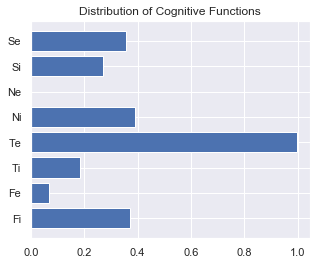

In [68]:
# Classify sample post
classify_post('sample_post.txt')

 Per our
predicted results, the author of the excerpt is most probable to display primary extraverted thinking and introverted intuition
functions.   


Note that while the user may in some cases show to have high incidences of two functions of the same orientation, per the Jungian theory, only one primary function 
can be of each orientation.  Therefore our optimization algorithm will prioritize the function of the orietation
that renders the highest probability of being possessed.  If the other primary function is of the same orientation,
it will keep taking the next cognitive function it finds to have the next highestprobability of being present 
and finally settle on the one it finds of the opposite orientation.  

# Conclusion

Overall it is not totally clear if cognitive functions can be accurately predicted by text alone.
The features used in this data were garnered from a list of 50 user posts each and were all from a personality
forum.  It is unclear if data not from a personality forum that is shorter in length will classify as well. 
60-70 AUC scores per cognitive function arent very bad, but also dont constitute a model that should be
used for any purpose other than entertainment.

# Caveats

Just to summarize, A few caveats of this model include

- The model was only tested on forum data (downsampling and topic cleaning helps, but still can be biased)
- The model was only tested on data that included 50 posts for each user
- Model only demonstrated AUCs in the high 60s- low 70s
- Jungian cognitive functions are not necessarily a fool proof metric for personality

# Future Improvements

If we had more time I would definitely want to get more non forum data and integrate that in the model to 
better generalize it.  Additionally, I would want to see how text sample size fares with how accurate our model
is.   